<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript
from google.colab import files

import os
import shutil
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install yahooquery
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import StocksData
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback

In [2]:
NUM_SESSIONS = 15  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.8, 0.12, 0.08
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

## **1) Preparing the data**

#### **1.1) Fetching stocks prices**

   [TIME INTERVAL] from 2007-01-02 to 2020-12-08
[TRADING SESSIONS] 3442

>>> DATA:


,volume,open,close,high,low,adjclose
date,,,,,,
2007-01-02,75560200.0,44476.000000,45383.000000,45388.000000,44476.0000,45383.000000
2007-01-03,122372800.0,45379.000000,44445.000000,45379.000000,44284.0000,44445.000000
2007-01-04,86577000.0,44442.000000,44020.000000,44442.000000,43623.0000,44020.000000
2007-01-05,164055000.0,44019.000000,42245.000000,44081.000000,42160.0000,42245.000000
2007-01-08,114007100.0,42249.000000,42830.000000,42926.000000,42144.0000,42830.000000
...,...,...,...,...,...,...
2020-12-02,9814300.0,111402.000000,111814.000000,112315.000000,110579.0000,111814.000000
2020-12-03,11474200.0,111874.000000,112919.000000,113377.000000,111874.0000,112919.000000
2020-12-04,8892900.0,112294.000000,113682.000000,113864.000000,112294.0000,113682.000000




>>> STATS:


,volume,open,close,high,low,adjclose
count,3.442000e+03,3442.000000,3442.000000,3442.000000,3442.000000,3442.000000
mean,8.223796e+06,64582.573728,64602.854797,65256.117996,63913.438499,64602.854797
std,2.272383e+07,17585.367201,17607.819433,17685.512313,17500.414655,17607.819433
min,0.000000e+00,29438.000000,29435.000000,31480.000000,29435.000000,29435.000000
25%,2.242700e+06,52759.750000,52767.250000,53314.750000,52191.750000,52767.250000
50%,3.310100e+06,60432.500000,60455.500000,61189.500000,59817.500000,60455.500000
75%,4.577375e+06,70386.750000,70400.000000,70964.000000,69711.500000,70400.000000
max,2.322653e+08,119528.000000,119528.000000,119593.000000,118108.000000,119528.000000


<IPython.core.display.Javascript object>

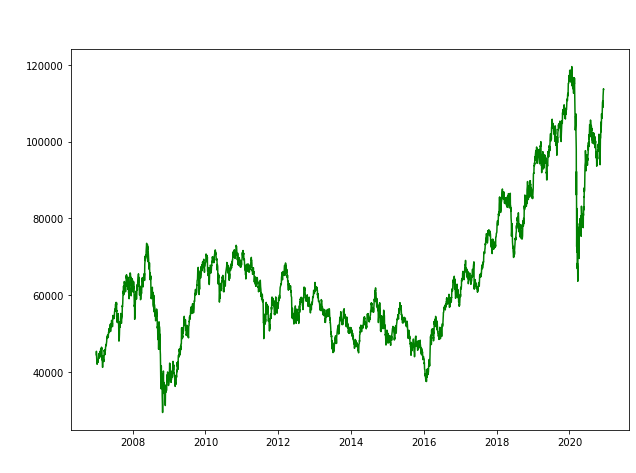

In [3]:
data = Ticker("^BVSP").history(start="2007-01-01",
                               #end="2017-12-31",
                               #period="max",
                               interval="1d")
data.reset_index("symbol", inplace=True, drop=True)

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[-1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data)

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["open"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the opening prices\n", fontsize=20, color="#ffffff");
ax.set_ylabel("Opening prices", fontsize="15", color="#ffffff");
ax.set_xlabel("Date", fontsize="15", color="#ffffff");

Javascript("google.colab.output.setIframeHeight('500px');")

#### **1.2) Pre-processing data**

In [4]:
data = StocksData(
    data_df=data,
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,    
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    batch_size=32,
)

print("  [TRAINING RANGE] %s to %s" % (
    data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
print("[VALIDATION RANGE] %s to %s" % (
    data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
print("      [TEST RANGE] %s to %s" % (
    data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))

  [TRAINING RANGE] 2007-01-02 to 2018-01-30
[VALIDATION RANGE] 2018-01-31 to 2019-10-03
      [TEST RANGE] 2019-10-04 to 2020-11-16


In [5]:
print(">>> NORMALIZED TRAINING DATA:")
display(data.norm_train["features"].tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(data.norm_val["features"].tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(data.norm_test["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

>>> NORMALIZED TRAINING DATA:


,volume,open,close,high,low
date,,,,,
2018-01-23,0.015978,0.931275,0.913488,0.928678,0.930481
2018-01-24,0.023696,0.913501,0.967003,0.965755,0.933304
2018-01-26,0.023295,0.967001,1.000000,1.000000,0.987961
2018-01-29,0.016746,1.000000,0.985150,1.000000,1.000000
2018-01-30,0.015353,0.985132,0.981300,0.984570,0.990220




>>> NORMALIZED VALIDATION DATA:


,volume,open,close,high,low
date,,,,,
2019-09-27,0.014945,1.352771,1.348456,1.371908,1.367264
2019-09-30,0.016773,1.348457,1.342520,1.363490,1.369668
2019-10-01,0.017634,1.342538,1.330184,1.362435,1.355080
2019-10-02,0.021812,1.330130,1.276312,1.342602,1.302390
2019-10-03,0.020087,1.276327,1.284958,1.296553,1.282027




>>> NORMALIZED TEST DATA:


,volume,open,close,high,low
date,,,,,
2020-11-10,0.071751,1.320628,1.353323,1.374221,1.348086
2020-11-11,0.046675,1.348279,1.338723,1.368744,1.360653
2020-11-12,0.046758,1.343697,1.296706,1.360548,1.322242
2020-11-13,0.042073,1.302676,1.338366,1.354776,1.330893
2020-11-16,0.050478,1.342253,1.372558,1.388281,1.371326


<IPython.core.display.Javascript object>

In [6]:
sample_x, sample_y = next(iter(data.train_ds))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 15, 5)
Sample label shape: (32, 3)


## **2) Defining a model**

In [8]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="tanh"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

        self._pre_lowest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="tanh"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

        self._pre_highest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="tanh"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [9]:
# testing output shape
x, y = next(iter(data.train_ds))
MultiLSTM()(x).shape

TensorShape([32, 3])

## **3) Training the model**

In [ ]:
save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=5e-5),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 2
history = model.fit(data.train_ds.shuffle(buffer_size=len(data.train_ds)), 
                    validation_data=data.val_ds,
                    epochs=epochs,
                    callbacks=[ClearCallback(),
                               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                               monitor='val_loss', 
                                               verbose=1, save_best_only=True)])

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving and downloading the model
model.save(save_path)
shutil.make_archive(save_path, "zip", save_path)
files.download(f"{save_path}.zip")

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **3) Evaluating the model**

#### **3.1) Training data**

     Training Data

#########################

[> GENERAL <]
   . MAE:   2410
   . MAPE:  3.6917%
   . MSE:   11903588

#########################

[> OPEN <]
   . MAE:   2410
   . MAPE:  3.6915%
   . MSE:   11902437
   . Tendency Accuracy:  55.8381%

#########################

[> LOW <]
   . MAE:   2410
   . MAPE:  3.6913%
   . MSE:   11901359
   . Tendency Accuracy:  48.0659%

#########################

[> HIGH <]
   . MAE:   2410
   . MAPE:  3.6911%
   . MSE:   11900266
   . Tendency Accuracy:  46.9914%

#########################


<IPython.core.display.Javascript object>

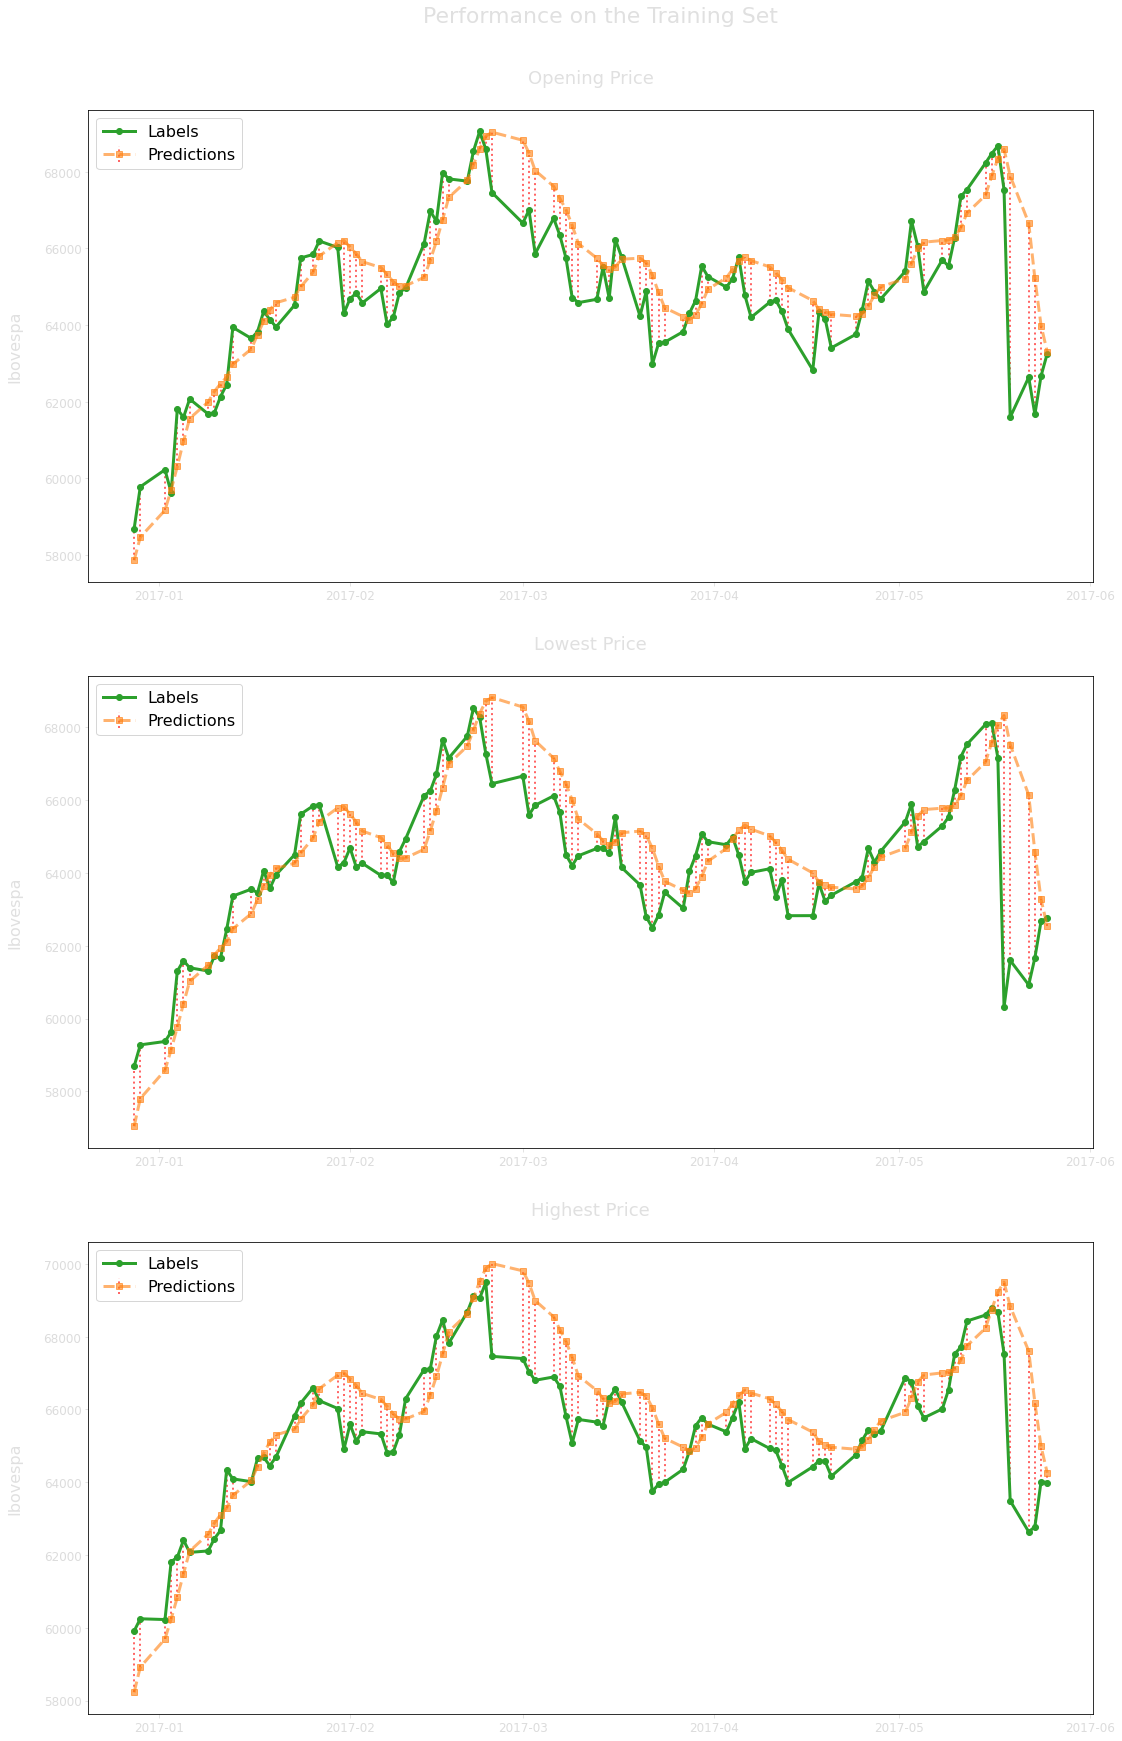

In [41]:
train_predictions, train_results = eval(model, data, "train")

print("     Training Data\n")
eval_print(train_results)

eval_plot(train_predictions, 
          data.raw_train["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Training Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   2389
   . MAPE:  3.6210%
   . MSE:   11670867

#########################

[> OPEN <]
   . MAE:   2388
   . MAPE:  3.6208%
   . MSE:   11670105
   . Tendency Accuracy:  55.7789%

#########################

[> LOW <]
   . MAE:   2388
   . MAPE:  3.6206%
   . MSE:   11669621
   . Tendency Accuracy:  52.5126%

#########################

[> HIGH <]
   . MAE:   2388
   . MAPE:  3.6205%
   . MSE:   11669214
   . Tendency Accuracy:  47.7387%

#########################


<IPython.core.display.Javascript object>

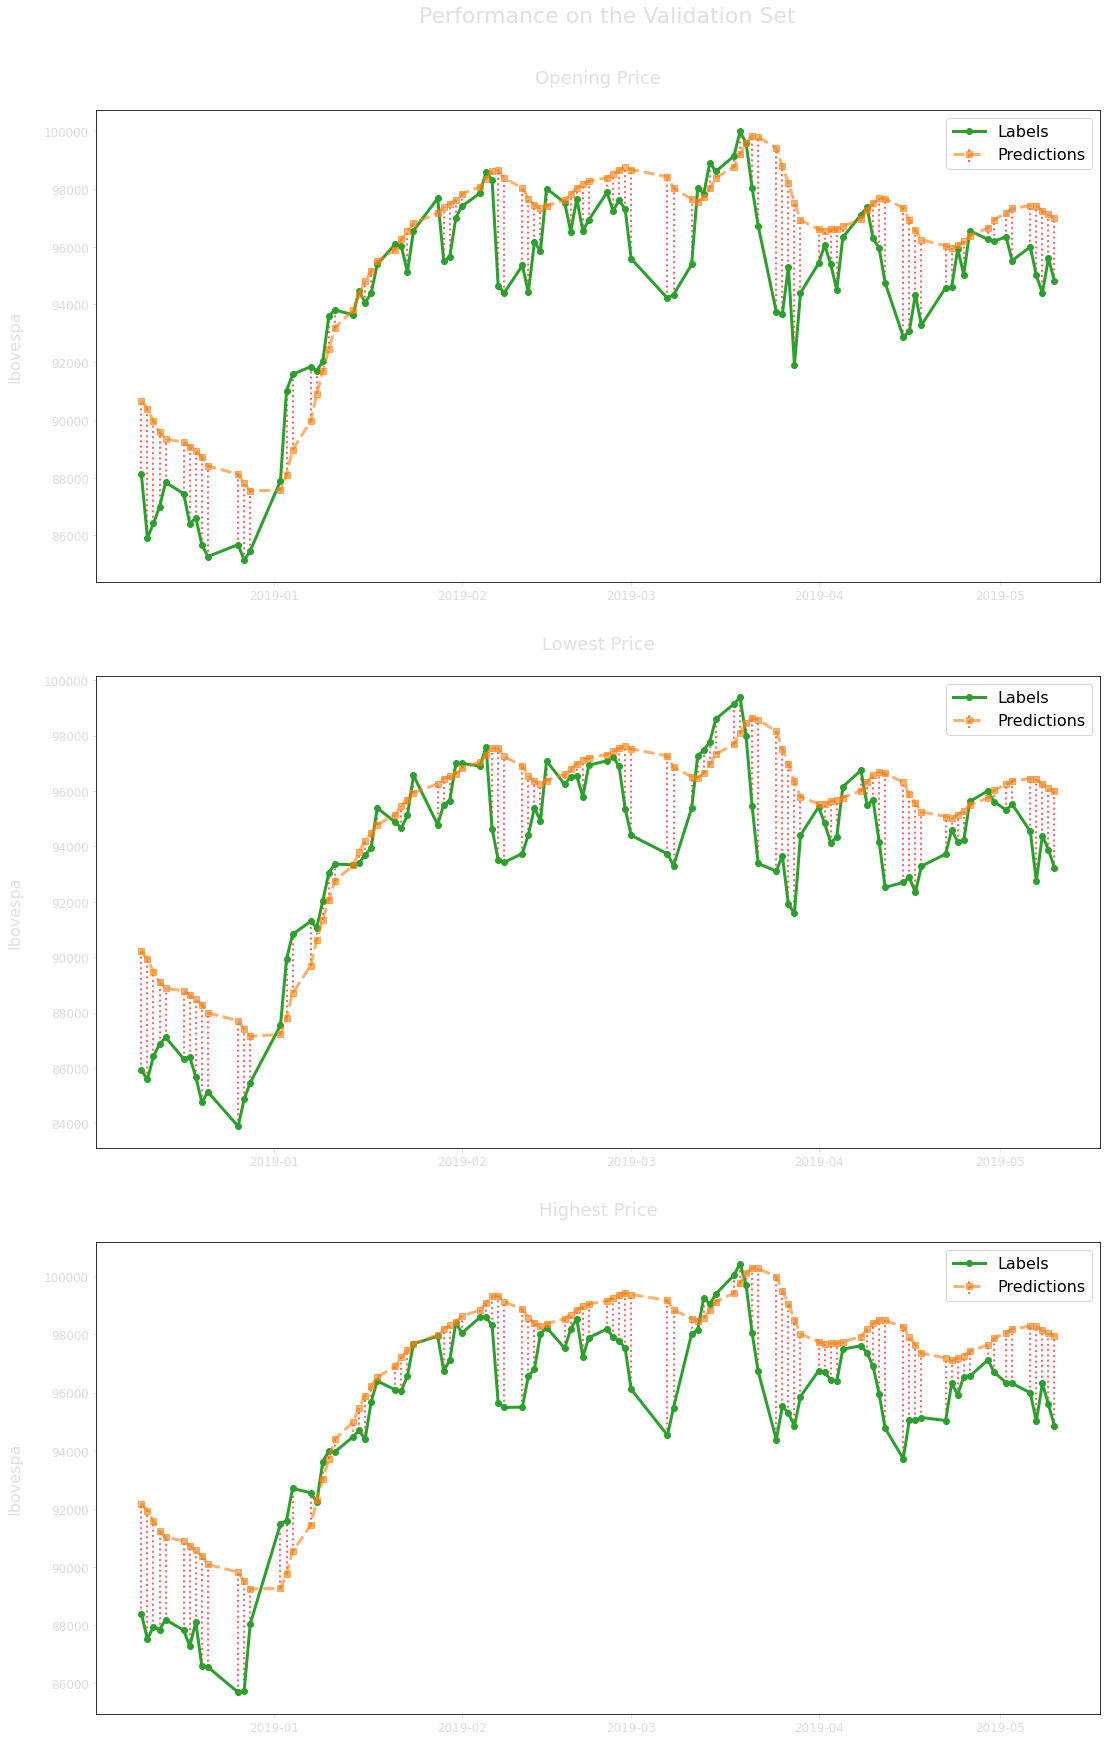

In [42]:
val_predictions, val_results = eval(model, data, "val")

print("     Validation Data\n")
eval_print(val_results)

eval_plot(val_predictions, 
          data.raw_val["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Validation Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.3) Test data**

     Test Data

#########################

[> GENERAL <]
   . MAE:   1528
   . MAPE:  2.2606%
   . MSE:   5846223

#########################

[> OPEN <]
   . MAE:   1528
   . MAPE:  2.2606%
   . MSE:   5846241
   . Tendency Accuracy:  55.8282%

#########################

[> LOW <]
   . MAE:   1529
   . MAPE:  2.2612%
   . MSE:   5851863
   . Tendency Accuracy:  42.3313%

#########################

[> HIGH <]
   . MAE:   1529
   . MAPE:  2.2614%
   . MSE:   5853683
   . Tendency Accuracy:  49.0798%

#########################


<IPython.core.display.Javascript object>

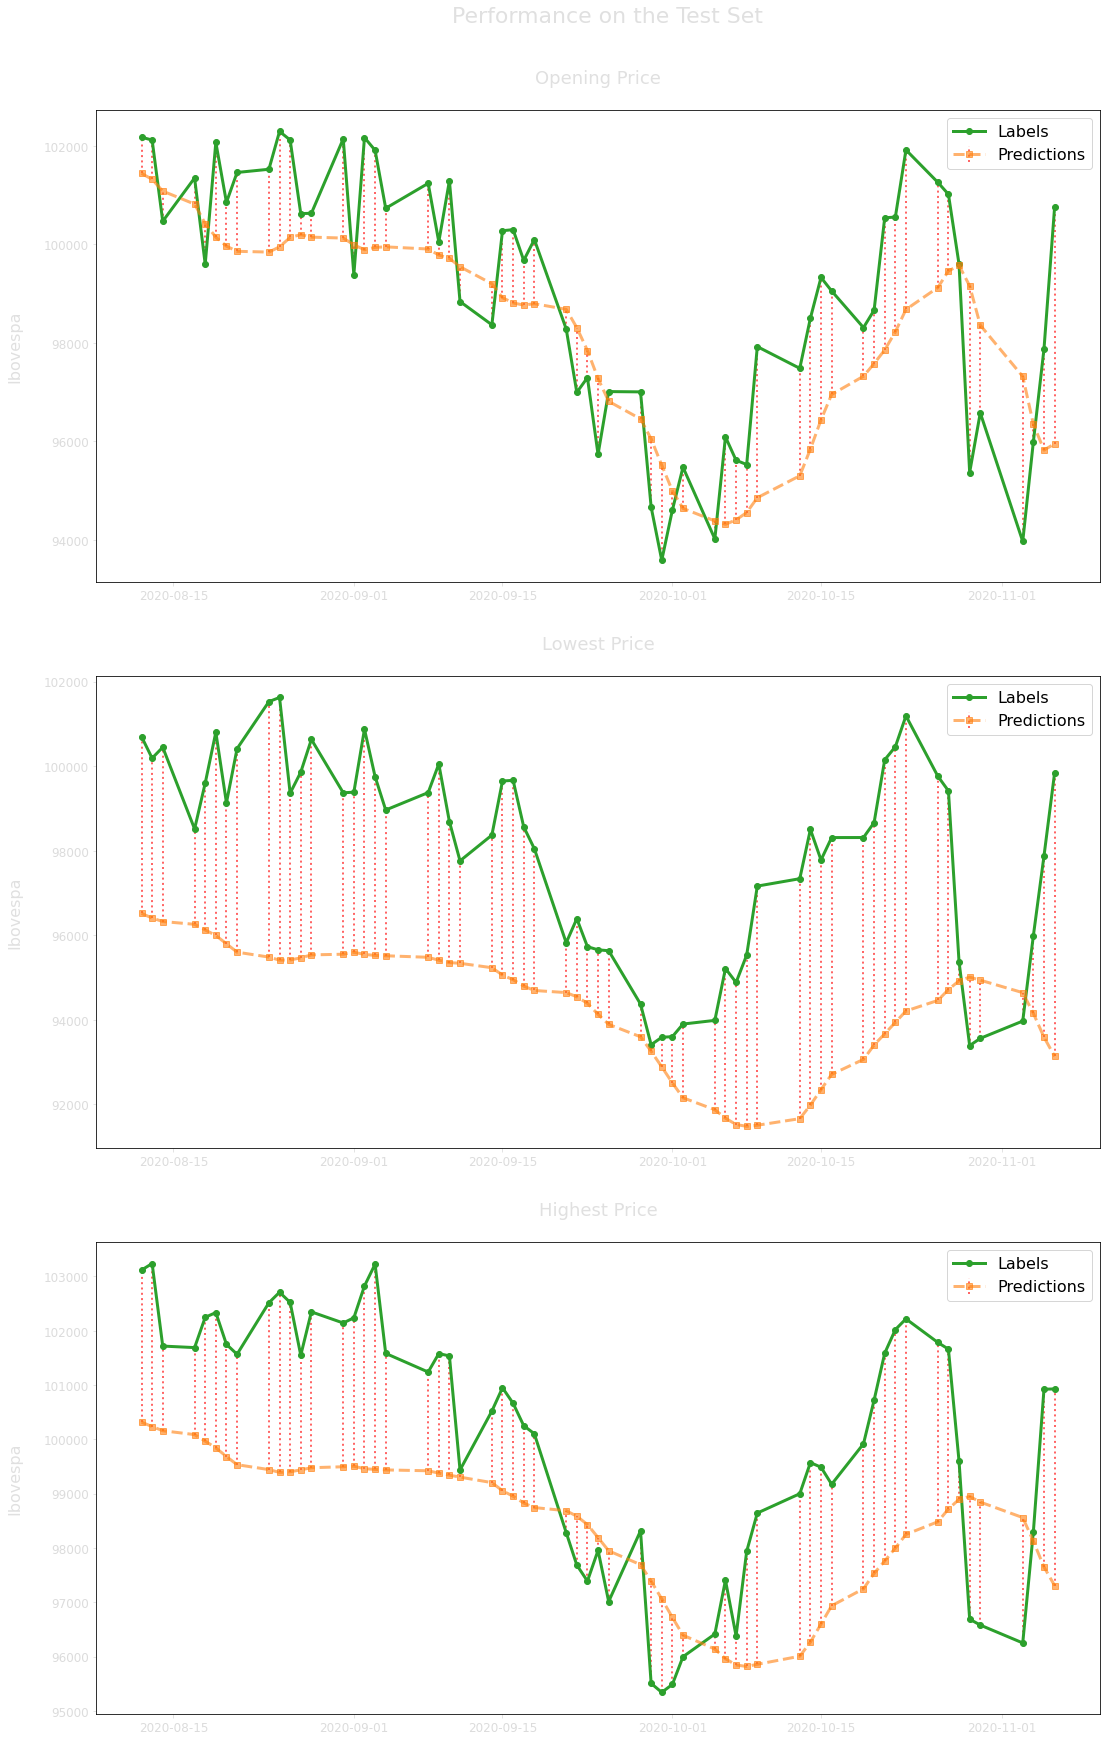

In [13]:
test_predictions, test_results = eval(model, data, "test")

print("     Test Data\n")
eval_print(test_results)

eval_plot(test_predictions, 
          data.raw_test["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Test Set")

Javascript("google.colab.output.setIframeHeight('600px');")